In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway, kruskal

from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
import torch.nn as nn
from transformers import AutoModel
from transformers import get_scheduler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertForSequenceClassification

In [8]:
def chi_squared_test(df, col1, col2):
    contingency = pd.crosstab(df[col1], df[col2])
    stat, p, dof, expected = chi2_contingency(contingency)
    print(f'Chi-cuadrado entre {col1} y {col2}:')
    print(f'Estadístico = {stat:.3f}, p-valor = {p:.4f}\n')
    return contingency

In [9]:
def build_input_text(row):
    return f"Condition: {row['Condition']}. Clinical note: {row['Clinical Note']}"

## Cargar los datos

In [10]:
df = pd.read_csv(r'/kaggle/input/brain-conditions-detailed-dataset/brain_conditions_detailed_dataset.csv', sep=';')
df.head()

,Case ID,Condition,Age,Sex,Clinical Note,Treatment
0,brain_glioma_0001,Brain Glioma,74,F,Patient is experiencing memory lapses and spee...,surgery
1,brain_glioma_0002,Brain Glioma,66,F,Patient is experiencing visual disturbances an...,chemotherapy
2,brain_glioma_0003,Brain Glioma,62,F,Patient is experiencing memory lapses and dizz...,surgery
3,brain_glioma_0004,Brain Glioma,24,M,Patient is experiencing memory lapses and pers...,surgery
4,brain_glioma_0005,Brain Glioma,69,M,Patient is experiencing dizziness and frequent...,surgery


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Case ID        6012 non-null   object
 1   Condition      6056 non-null   object
 2   Age            6056 non-null   int64 
 3   Sex            6056 non-null   object
 4   Clinical Note  6056 non-null   object
 5   Treatment      6056 non-null   object
dtypes: int64(1), object(5)
memory usage: 284.0+ KB


In [12]:
df = df.reset_index().drop('Case ID', axis= 1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          6056 non-null   int64 
 1   Condition      6056 non-null   object
 2   Age            6056 non-null   int64 
 3   Sex            6056 non-null   object
 4   Clinical Note  6056 non-null   object
 5   Treatment      6056 non-null   object
dtypes: int64(2), object(4)
memory usage: 284.0+ KB
None


,index,Condition,Age,Sex,Clinical Note,Treatment
0,0,Brain Glioma,74,F,Patient is experiencing memory lapses and spee...,surgery
1,1,Brain Glioma,66,F,Patient is experiencing visual disturbances an...,chemotherapy
2,2,Brain Glioma,62,F,Patient is experiencing memory lapses and dizz...,surgery
3,3,Brain Glioma,24,M,Patient is experiencing memory lapses and pers...,surgery
4,4,Brain Glioma,69,M,Patient is experiencing dizziness and frequent...,surgery


In [13]:
df.loc[0,'Clinical Note']

'Patient is experiencing memory lapses and speech difficulties for the last few weeks. The symptoms are described as intense in nature.'

# Análisis Descriptivo

In [14]:
print(df['Condition'].value_counts(normalize=True) * 100)
print(df['Sex'].value_counts(normalize=True) * 100)
print(df['Treatment'].value_counts(normalize=True) * 100)

Condition
Brain Tumor          33.817701
Brain Glioma         33.091149
Brain Meningiomas    33.091149
Name: proportion, dtype: float64
Sex
F    50.84214
M    49.15786
Name: proportion, dtype: float64
Treatment
radiation therapy    31.291281
surgery              30.515192
chemotherapy         19.385733
close monitoring     18.807794
Name: proportion, dtype: float64


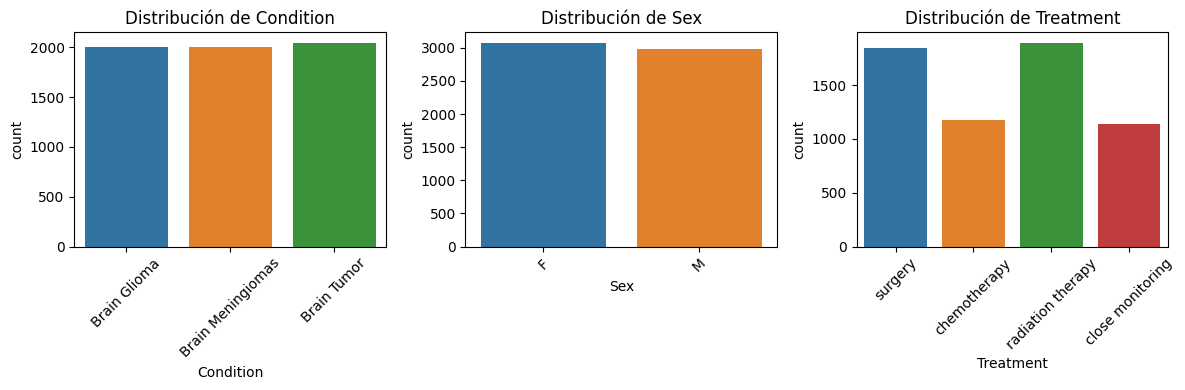

In [15]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(['Condition', 'Sex', 'Treatment']):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las categorías en las diferentes variables se encuentran bien balanceadas en general.

count    6056.000000
mean       51.764531
std        19.619781
min        18.000000
25%        35.000000
50%        52.000000
75%        69.000000
max        85.000000
Name: Age, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


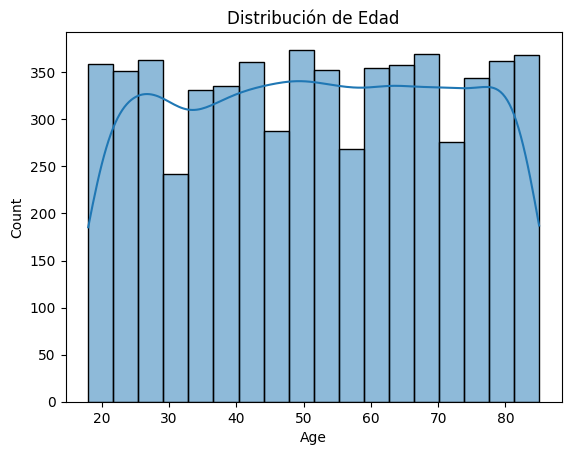

In [16]:
print(df['Age'].describe())
sns.histplot(df['Age'], kde=True)
plt.title('Distribución de Edad')
plt.show()

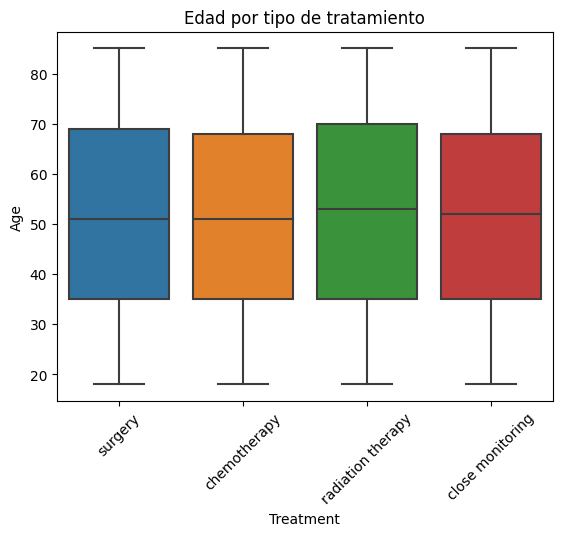

In [17]:
sns.boxplot(data=df, x='Treatment', y='Age')
plt.title('Edad por tipo de tratamiento')
plt.xticks(rotation=45)
plt.show()

La edad promedio es de 52 años y no se evidencia visualmente una diferencia significativa entre la edad y el tratamiento.

In [18]:
# Agrupar edades por tipo de tratamiento
groups = [df[df['Treatment'] == t]['Age'] for t in df['Treatment'].unique()]

# Kruskal-Wallis. Lo utilizo porque la edad no se distribuye normal
kruskal_stat, kruskal_p = kruskal(*groups)
print(f'Kruskal-Wallis Edad vs Tratamiento: H = {kruskal_stat:.3f}, p = {kruskal_p:.4f}')

Kruskal-Wallis Edad vs Tratamiento: H = 2.865, p = 0.4129


Valor p > 0.05. Rechazo Ho, no hay evidencia estadística suficiente para afirmar que la edad tiene una distribución diferente según el tratamiento asignado. No se tiene en cuenta para el entrenamiento del modelo.

In [19]:
chi_squared_test(df, 'Treatment', 'Condition')
chi_squared_test(df, 'Treatment', 'Sex')

Chi-cuadrado entre Treatment y Condition:
Estadístico = 1273.788, p-valor = 0.0000

Chi-cuadrado entre Treatment y Sex:
Estadístico = 2.833, p-valor = 0.4181



Sex,F,M
Treatment,,
chemotherapy,587,587
close monitoring,590,549
radiation therapy,985,910
surgery,917,931


Hay una relación estadísticamente significativa entre la condición del paciente y el tratamiento recibido. Sin embargo, no hay evidencia suficiente para afirmar que el tratamiento depende del sexo del paciente. Por lo que se considera eliminar esta variable para el entrenamiento del modelo.


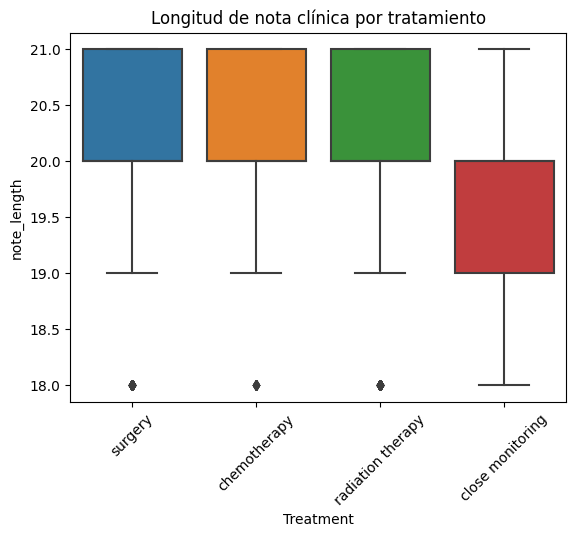

                    count       mean       std   min   25%   50%   75%   max
Treatment                                                                   
chemotherapy       1174.0  20.287905  0.678929  18.0  20.0  20.0  21.0  21.0
close monitoring   1139.0  19.884109  0.839859  18.0  19.0  20.0  20.0  21.0
radiation therapy  1895.0  20.035356  0.810644  18.0  20.0  20.0  21.0  21.0
surgery            1848.0  20.078463  0.809266  18.0  20.0  20.0  21.0  21.0


In [20]:
df['note_length'] = df['Clinical Note'].apply(lambda x: len(x.split()))

sns.boxplot(data=df, x='Treatment', y='note_length')
plt.title('Longitud de nota clínica por tratamiento')
plt.xticks(rotation=45)
plt.show()

print(df.groupby('Treatment')['note_length'].describe())

En general, la cantidad de palabras en notas medicas es igual para los diferentes tratamientos, excepto para close monitoring donde se evidencia una distribución menor en comparación con los demás tratamientos.

Se crea una nueva variable que concatene la variable Condition y Clinical Note. Con esta nueva variable se entrena el modelo.

In [21]:
df['input_text'] = df.apply(build_input_text, axis=1)
df

,index,Condition,Age,Sex,Clinical Note,Treatment,note_length,input_text
0,0,Brain Glioma,74,F,Patient is experiencing memory lapses and spee...,surgery,21,Condition: Brain Glioma. Clinical note: Patien...
1,1,Brain Glioma,66,F,Patient is experiencing visual disturbances an...,chemotherapy,20,Condition: Brain Glioma. Clinical note: Patien...
2,2,Brain Glioma,62,F,Patient is experiencing memory lapses and dizz...,surgery,20,Condition: Brain Glioma. Clinical note: Patien...
3,3,Brain Glioma,24,M,Patient is experiencing memory lapses and pers...,surgery,21,Condition: Brain Glioma. Clinical note: Patien...
4,4,Brain Glioma,69,M,Patient is experiencing dizziness and frequent...,surgery,20,Condition: Brain Glioma. Clinical note: Patien...
...,...,...,...,...,...,...,...,...
6051,6051,Brain Tumor,52,F,Patient is experiencing speech problems and ba...,radiation therapy,21,Condition: Brain Tumor. Clinical note: Patient...
6052,6052,Brain Tumor,49,F,Patient is experiencing nausea and difficulty ...,surgery,20,Condition: Brain Tumor. Clinical note: Patient...
6053,6053,Brain Tumor,38,F,Patient is experiencing nausea and balance iss...,close monitoring,20,Condition: Brain Tumor. Clinical note: Patient...
6054,6054,Brain Tumor,65,M,Patient is experiencing balance issues and dif...,radiation therapy,21,Condition: Brain Tumor. Clinical note: Patient...


In [22]:
df_mod = df.loc[:,['Treatment', 'input_text']].copy()
print(df_mod.info())
df_mod.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Treatment   6056 non-null   object
 1   input_text  6056 non-null   object
dtypes: object(2)
memory usage: 94.8+ KB
None


,Treatment,input_text
0,surgery,Condition: Brain Glioma. Clinical note: Patien...
1,chemotherapy,Condition: Brain Glioma. Clinical note: Patien...
2,surgery,Condition: Brain Glioma. Clinical note: Patien...
3,surgery,Condition: Brain Glioma. Clinical note: Patien...
4,surgery,Condition: Brain Glioma. Clinical note: Patien...


## Preprocesamiento

In [23]:
label_enc = LabelEncoder()
df_mod['label'] = label_enc.fit_transform(df_mod['Treatment'])
df_mod.head()

,Treatment,input_text,label
0,surgery,Condition: Brain Glioma. Clinical note: Patien...,3
1,chemotherapy,Condition: Brain Glioma. Clinical note: Patien...,0
2,surgery,Condition: Brain Glioma. Clinical note: Patien...,3
3,surgery,Condition: Brain Glioma. Clinical note: Patien...,3
4,surgery,Condition: Brain Glioma. Clinical note: Patien...,3


In [24]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") ## Entrenado con datos clinicos. Mejora la comprensión semántica del modelo para tareas clínicas. A diferencia de BERT o RoBERTa
MAX_LEN = 50

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [25]:
class ClinicalNoteDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts) # Devuelve el número total de muestras

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [26]:
X = df_mod['input_text'].tolist()
y = df_mod['label'].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # stratify asegura que la distribución de clases se mantenga en cada subconjunto.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [27]:
BATCH_SIZE = 16

In [28]:
train_dataset = ClinicalNoteDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = ClinicalNoteDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = ClinicalNoteDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [29]:
class ClinicalBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ClinicalBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output  # [CLS] token
        output = self.dropout(pooled_output)
        return self.out(output)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Entrenamiento

In [56]:
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=len(label_enc.classes_),
    problem_type="single_label_classification"
)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
#model = ClinicalBERTClassifier(n_classes=len(label_enc.classes_))
#model = model.to(device)

In [57]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [58]:
EPOCHS = 5

In [59]:
num_training_steps = len(train_loader) * EPOCHS
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [66]:
def train_epoch(model, data_loader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0
    true_labels, pred_labels = [], []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        _, preds = torch.max(logits, dim=1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    acc = accuracy_score(true_labels, pred_labels)
    return total_loss / len(data_loader), acc

In [67]:
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            _, preds = torch.max(logits, dim=1)

            total_loss += loss.item()
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    acc = accuracy_score(true_labels, pred_labels)
    return total_loss / len(data_loader), acc

In [68]:
best_acc = 0
best_model_path = 'best_clinicalbert_model.pth'

In [69]:
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, lr_scheduler, device)
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)

    print(f'Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}')
    print(f'Val loss:   {val_loss:.4f} | Val acc:   {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Nuevo mejor modelo guardado con Accuracy = {best_acc:.4f}")


--- Epoch 1/5 ---
Train loss: 1.2743 | Train acc: 0.2989
Val loss:   1.2245 | Val acc:   0.3018
✅ Nuevo mejor modelo guardado con Accuracy = 0.3018

--- Epoch 2/5 ---
Train loss: 1.2131 | Train acc: 0.3159
Val loss:   1.2062 | Val acc:   0.3073
✅ Nuevo mejor modelo guardado con Accuracy = 0.3073

--- Epoch 3/5 ---
Train loss: 1.2097 | Train acc: 0.3159
Val loss:   1.2089 | Val acc:   0.3018

--- Epoch 4/5 ---
Train loss: 1.2057 | Train acc: 0.3090
Val loss:   1.2022 | Val acc:   0.2941

--- Epoch 5/5 ---
Train loss: 1.1973 | Train acc: 0.3369
Val loss:   1.2044 | Val acc:   0.3062


In [70]:
model.load_state_dict(torch.load('best_clinicalbert_model.pth'))
model = model.to(device)

In [76]:
model.save_pretrained("clinicalbert-treatment-classifier")
tokenizer.save_pretrained("clinicalbert-treatment-classifier")

('clinicalbert-treatment-classifier/tokenizer_config.json',
 'clinicalbert-treatment-classifier/special_tokens_map.json',
 'clinicalbert-treatment-classifier/vocab.txt',
 'clinicalbert-treatment-classifier/added_tokens.json',
 'clinicalbert-treatment-classifier/tokenizer.json')

In [79]:
def test_model(model, data_loader, device):
    model.eval()
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # ← CORRECCIÓN CLAVE
            _, preds = torch.max(logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    acc = accuracy_score(true_labels, pred_labels)
    return true_labels, pred_labels, acc

y_true, y_pred, test_acc = test_model(model, test_loader, device)
print(f"\n📊 Accuracy en el test set: {test_acc:.4f}")


📊 Accuracy en el test set: 0.3069


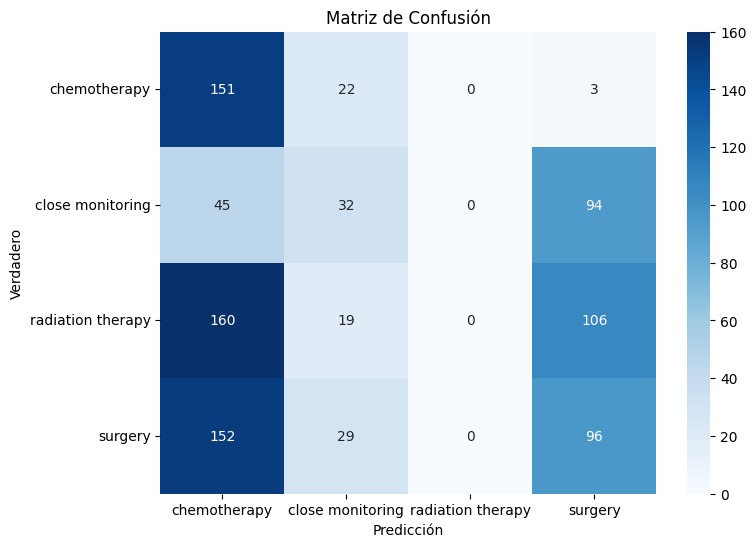


🔍 Reporte de clasificación:
                   precision    recall  f1-score   support

     chemotherapy       0.30      0.86      0.44       176
 close monitoring       0.31      0.19      0.23       171
radiation therapy       0.00      0.00      0.00       285
          surgery       0.32      0.35      0.33       277

         accuracy                           0.31       909
        macro avg       0.23      0.35      0.25       909
     weighted avg       0.21      0.31      0.23       909



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
labels = label_enc.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

print("\n🔍 Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))


## Guardar modelo HuggingFace

In [44]:
from huggingface_hub import notebook_login
from huggingface_hub import create_repo
from huggingface_hub import upload_folder
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [45]:
notebook_login()

In [77]:
repo_id = "jherronr/clinicalbert-treatment-classifier"  

upload_folder(
    folder_path="clinicalbert-treatment-classifier",
    repo_id=repo_id,
    repo_type="model",
    allow_patterns="*"
)


model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jherronr/clinicalbert-treatment-classifier/commit/24e657950039c2c625d354c6432fc471343d94f2', commit_message='Upload folder using huggingface_hub', commit_description='', oid='24e657950039c2c625d354c6432fc471343d94f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jherronr/clinicalbert-treatment-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='jherronr/clinicalbert-treatment-classifier'), pr_revision=None, pr_num=None)

In [78]:
from transformers import pipeline

clf = pipeline("text-classification", model=repo_id, tokenizer=repo_id)
text = "Condition: Brain Glioma. Clinical note: Patient has experienced seizures and blurry vision."
print(clf(text))

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'LABEL_3', 'score': 0.3457399904727936}]
